Se importan las siguiente librerías:
- pandas: para poder cargar el dataset
- numpy: para poder manipular los arreglos y usar vectorización
- matplotlib: para graficar
- sklearn: para poder usar el label encoding, estandarizar, one-hot encoding y calcular las métricas

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from scipy.special import softmax

Se cargan los datos del dataset.

In [36]:
df = pd.read_csv('Employee.csv')
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


Función para dividir el datasaet en subconjuntos.

In [37]:
def validate(partitions: tuple[int, ...], X = np.array, Y = np.array):
  assert type(partitions) == tuple, 'Partitions must be a tuple of ints'
  assert sum(partitions) == 100, 'Sum of paritions must be 100'
  assert type(X) == np.ndarray, 'X must be a NDArray'
  assert type(Y) == np.ndarray, 'X must be a NDArray'
  assert X.shape[0] == Y.shape[0], f'X and Y must have the same dimension'

def split_sequencial (partitions: tuple[int, ...], X = np.array, Y = np.array):
  validate(partitions, X, Y)

  length = X.shape[0]
  start_index = 0
  for partition in partitions:
    step = round(partition / 100 * length)
    end_index = start_index + step
    yield X[start_index:end_index]
    yield Y[start_index:end_index]
    start_index = end_index
    start_index = end_index

Se usa label encoding para los campos `Education`, `City`, `Gender` y `EverBenched` después las X se apilan en una matriz la cuál se estandariza. Finalmente se divide el conjunto en subconjuntos de entrenamiento y prueba.

In [38]:
X1 = LabelEncoder().fit_transform(df['Education']).astype(np.float64)
X2 = df['JoiningYear'].values.astype(np.float64)
X3 = LabelEncoder().fit_transform(df['City']).astype(np.float64)
X4 = df['Age'].values.astype(np.float64)
X5 = LabelEncoder().fit_transform(df['Gender']).astype(np.float64)
X6 = LabelEncoder().fit_transform(df['EverBenched']).astype(np.float64)
X7 = df['ExperienceInCurrentDomain'].values.astype(np.float64)
X8 = df['PaymentTier'].values.astype(np.float64)
Y = df['LeaveOrNot'].values
X = np.column_stack((X1, X2, X3, X4, X5, X6, X7, X8))
ss = StandardScaler()
X = ss.fit_transform(X)
X_train, Y_train, X_test, Y_test = split_sequencial((80, 20), X, Y)

Se define la clase para la regresión logistica multiclase. Similar a la regresión lineal, salvo que al producto obtenido mediante multiplicar X por los coeficientes (pendiente e intersección) se le aplica la función sigmoide.

In [39]:
onehot_encoder = OneHotEncoder(sparse_output=False)

def loss(X, Y, W):
    Z = - X @ W
    N = X.shape[0]
    loss = 1/N * (np.trace(X @ W @ Y.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))
    return loss

def gradient(X, Y, W, mu):
    Z = - X @ W
    P = softmax(Z, axis=1)
    N = X.shape[0]
    return 1/N * (X.T @ (Y - P)) + 2 * mu * W

class MulticlassLR:
    def __init__(self, iters=100, lr=0.001, mu=0.01):
        self.iters = iters
        self.lr = lr
        self.coefficients = None
        self.losses = []
        self.mu = mu

    def fit(self, X, Y):
        Y_onehot = onehot_encoder.fit_transform(Y.reshape(-1,1))
        X = np.column_stack([np.ones(X.shape[0]), X])
        self.coefficients = np.zeros((X.shape[1], Y_onehot.shape[1]))
        m = X.shape[0]

        for _ in range(self.iters):
            grad = gradient(X, Y_onehot, self.coefficients, self.mu)
            self.coefficients -= self.lr * grad
            self.losses.append(loss(X, Y_onehot, self.coefficients))

    def predict(self, X):
        X = np.column_stack([np.ones(X.shape[0]), X])
        a = - np.dot(X, self.coefficients)
        return np.argmax(softmax(a, axis=1), axis=1)

Se entrena el modelo

In [40]:
%%time
model = MulticlassLR(1000, 0.019)
model.fit(X_train, Y_train)

CPU times: user 6.64 s, sys: 4.23 s, total: 10.9 s
Wall time: 10.9 s


Se realiza la predicción de los datos de prueba y se obtiene los puntajes con las funciones:
- `accuracy_score`
- `precision_score`
- `f1_score`
- `recall_score` (Sensitivity)

In [41]:
predictions = model.predict(X_test)
print(f'Accuracy score with test dataset: {accuracy_score(Y_test, predictions)}')
print(f'Precision score (Macro) with test dataset: {precision_score(Y_test, predictions, average="macro", zero_division=0)}')
print(f'Precision score (Micro) with test dataset: {precision_score(Y_test, predictions, average="micro", zero_division=0)}')
print(f'Precision score (Weighted) with test dataset: {precision_score(Y_test, predictions, average="weighted", zero_division=0)}')
print(f'F1 score (Macro) with test dataset: {f1_score(Y_test, predictions, average="macro")}')
print(f'F1 score (Micro) with test dataset: {f1_score(Y_test, predictions, average="micro")}')
print(f'F1 score (Weighted) with test dataset: {f1_score(Y_test, predictions, average="weighted")}')
print(f'Sensitivity score (Macro) with test dataset: {recall_score(Y_test, predictions, average="macro", zero_division=0)}')
print(f'Sensitivity score (Micro) with test dataset: {recall_score(Y_test, predictions, average="micro", zero_division=0)}')
print(f'Sensitivity score (Weighted) with test dataset: {recall_score(Y_test, predictions, average="weighted", zero_division=0)}')

Accuracy score with test dataset: 0.7218045112781954
Precision score (Macro) with test dataset: 0.6781494581577363
Precision score (Micro) with test dataset: 0.7218045112781954
Precision score (Weighted) with test dataset: 0.7035583578150676
F1 score (Macro) with test dataset: 0.6329831034236078
F1 score (Micro) with test dataset: 0.7218045112781954
F1 score (Weighted) with test dataset: 0.6983385934825512
Sensitivity score (Macro) with test dataset: 0.6257182763491912
Sensitivity score (Micro) with test dataset: 0.7218045112781954
Sensitivity score (Weighted) with test dataset: 0.7218045112781954


Se gráfica la perdida conforme a las iteraciones.

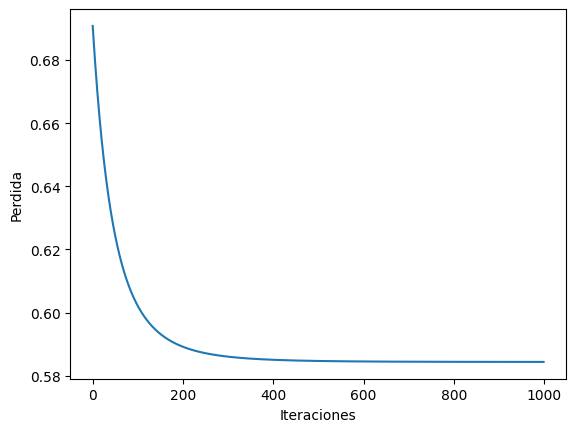

In [42]:
plt.plot(model.losses)
plt.xlabel("Iteraciones")
plt.ylabel("Perdida")
plt.savefig('./MLR-employee-loss.png')
plt.show()